# LoFi: Low-rank (extended) Kalman filter

In [1]:
import einops
import jax
import numpy as np
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt
from rebayes_mini import callbacks
from sklearn.datasets import make_moons

In [2]:
from rebayes_mini.methods import low_rank_filter as lofi

In [3]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Moons' dataset

In [4]:
n_samples = 500
n_test = 300
data = make_moons(n_samples=(n_samples + n_test), random_state=3141, noise=0.15)
X, y = jax.tree_map(jnp.array, data)
X_test, y_test = X[-n_test:], y[-n_test:]
X, y = X[:-n_test], y[:-n_test]

key = jax.random.PRNGKey(314)

In [5]:
%%time
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(50)(x)
        x = nn.relu(x)
        x = nn.Dense(50)(x)
        x = nn.relu(x)
        x = nn.Dense(50)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x



model = MLP()
agent = lofi.BernoulliFilter(
    model.apply,
    dynamics_covariance=1e-7,
    rank=100
)

params = model.init(key, X)
bel_init = agent.init_bel(params, cov=1e-3)
bel, _ = agent.scan(bel_init, y, X)


bel = jax.block_until_ready(bel)
yhat = jax.nn.sigmoid(agent.link_fn(bel.mean, X)).ravel() > 0.5
(yhat == y).mean()

CPU times: user 11.8 s, sys: 554 ms, total: 12.3 s
Wall time: 6.17 s


Array(0.864, dtype=float32)

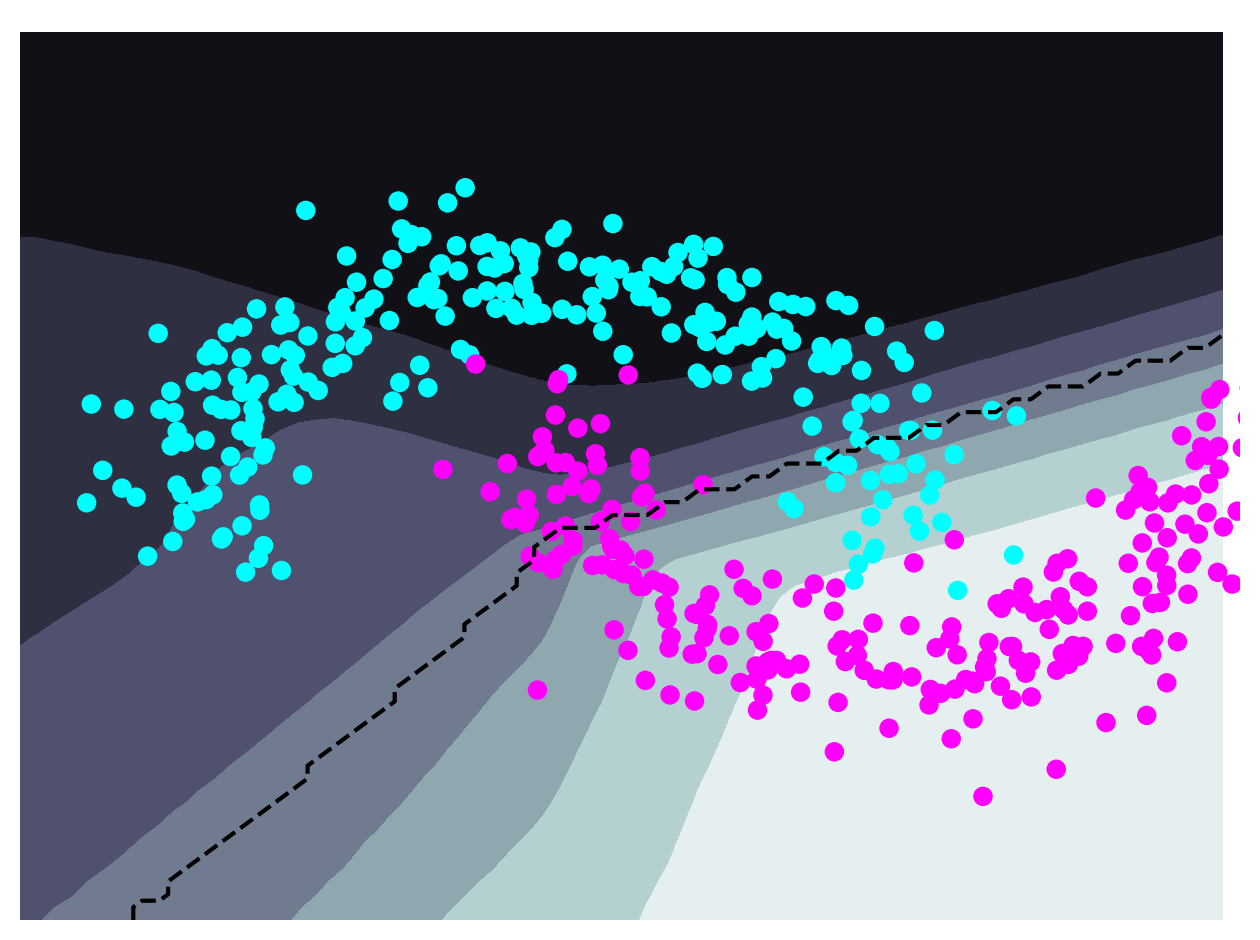

In [6]:
XX = np.mgrid[-1.5:2:0.05, -1.5:2:0.05]

Xeval = einops.rearrange(XX, "d x y -> x y d")

Z = agent.link_fn(bel.mean, Xeval).squeeze()
mean_Z = agent.mean(Z)

plt.contourf(*XX, mean_Z, cmap="bone")
plt.contour(*XX, mean_Z > 0.5, colors="black", linestyles="--")
plt.scatter(*np.array(X).T, c=y, cmap="cool")
plt.ylim(-1.5, 2)
plt.xlim(-1.5, 2)
plt.axis("off")
plt.tight_layout()

## Fashion MNIST

In [4]:
import keras

2023-10-21 13:30:52.227658: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
# X_train = einops.rearrange(X_train, "s w h -> s (w h)") / 255
# X_test = einops.rearrange(X_test, "s w h -> s (w h)") / 255
X_train = X_train[..., None] / 255
X_test = X_test[..., None] / 255 
y_train = jax.nn.one_hot(y_train, 10)
X_train = jnp.array(X_train)

In [6]:
X_eval = X_test[:5_000]
y_eval = y_test[:5_000]
def callbackfn(bel_update, bel_prev, y, x, agent):
    """
    Compute test accuracy at every timestep
    """
    yhat_eval = agent.link_fn(bel_update.mean, X_eval).argmax(axis=1)
    acc = (yhat_eval == y_eval).mean()
    return acc

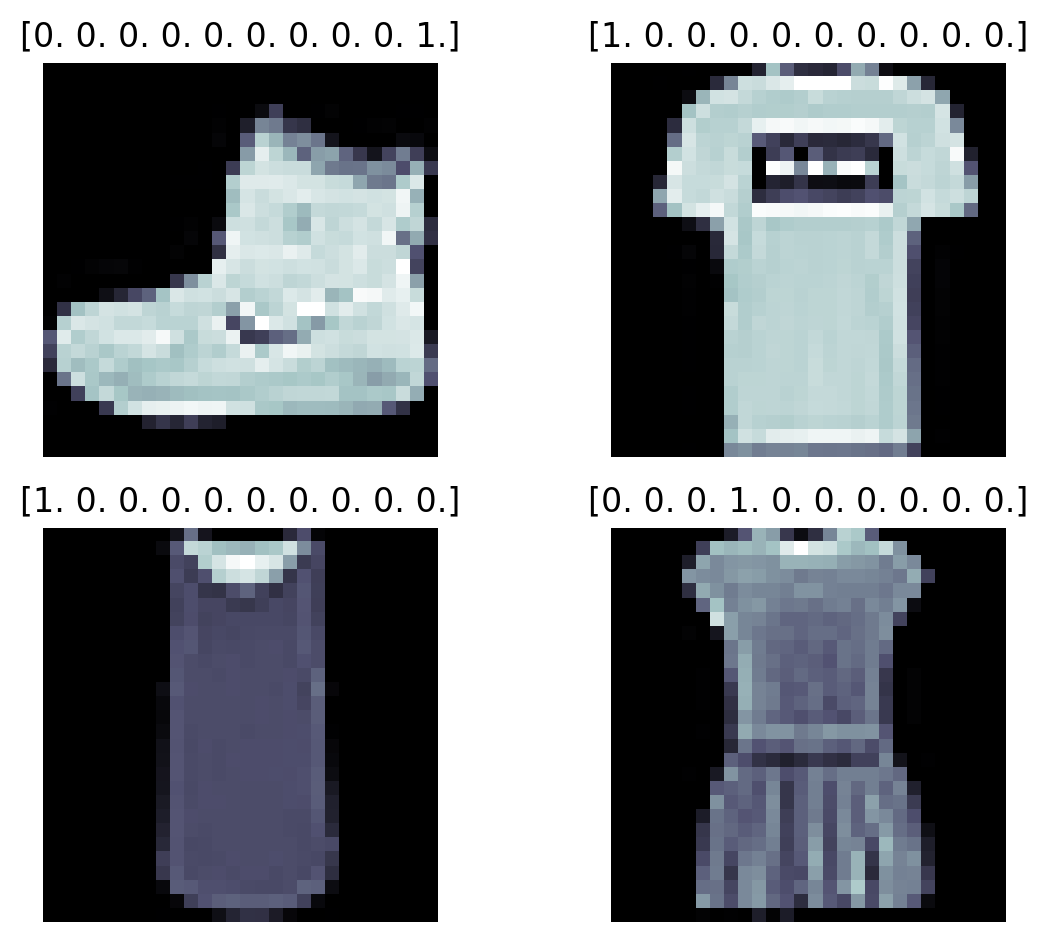

In [7]:
fig, axs = plt.subplots(2, 2)
for i, ax in enumerate(axs.ravel()):
    ax.imshow(X_train[i], cmap="bone")
    ax.set_title(y_train[i])
    ax.axis("off")
plt.tight_layout()

In [8]:
dim_in = (28, 28, 1)

In [55]:
class CNN(nn.Module):
    num_arms: int = 10

    @nn.compact
    def __call__(self, x):
        x = x if len(x.shape) > 3 else x[None, :]
        x = nn.Conv(features=6, kernel_size=(5, 5))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")
        x = nn.Conv(features=16, kernel_size=(5, 5), padding="VALID")(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")
        x = x.reshape((x.shape[0], -1))  # Flatten
        x = nn.Dense(features=120)(x)
        x = nn.relu(x)
        x = nn.Dense(features=84)(x)
        x = nn.relu(x)
        x = nn.Dense(10, name="output_layer")(x)
        x = x - jax.nn.logsumexp(x)
        return x.squeeze()
    
model = CNN()

In [13]:
from jax import config
from functools import partial
config.update("jax_debug_nans", True)


In [132]:
agent = lofi.MultinomialFilter(
    model.apply,
    dynamics_covariance=0.0,
    rank=50
)

In [143]:
%%time
key = jax.random.PRNGKey(314)
params = model.init(key, X_train[:10])
bel_init = agent.init_bel(params, cov=1e-4)

cfn = partial(callbackfn, agent=agent)
bel, hist_lofi = agent.scan(bel_init, y_train[:10_000], X_train[:10_000], callback=cfn)
bel = jax.block_until_ready(bel)

CPU times: user 37.8 s, sys: 1.31 s, total: 39.1 s
Wall time: 2min 43s


In [144]:
bel.diagonal

Array([107186.766, 107205.305, 105706.81 , ..., 102490.61 , 101628.56 ,
       101573.914], dtype=float32)

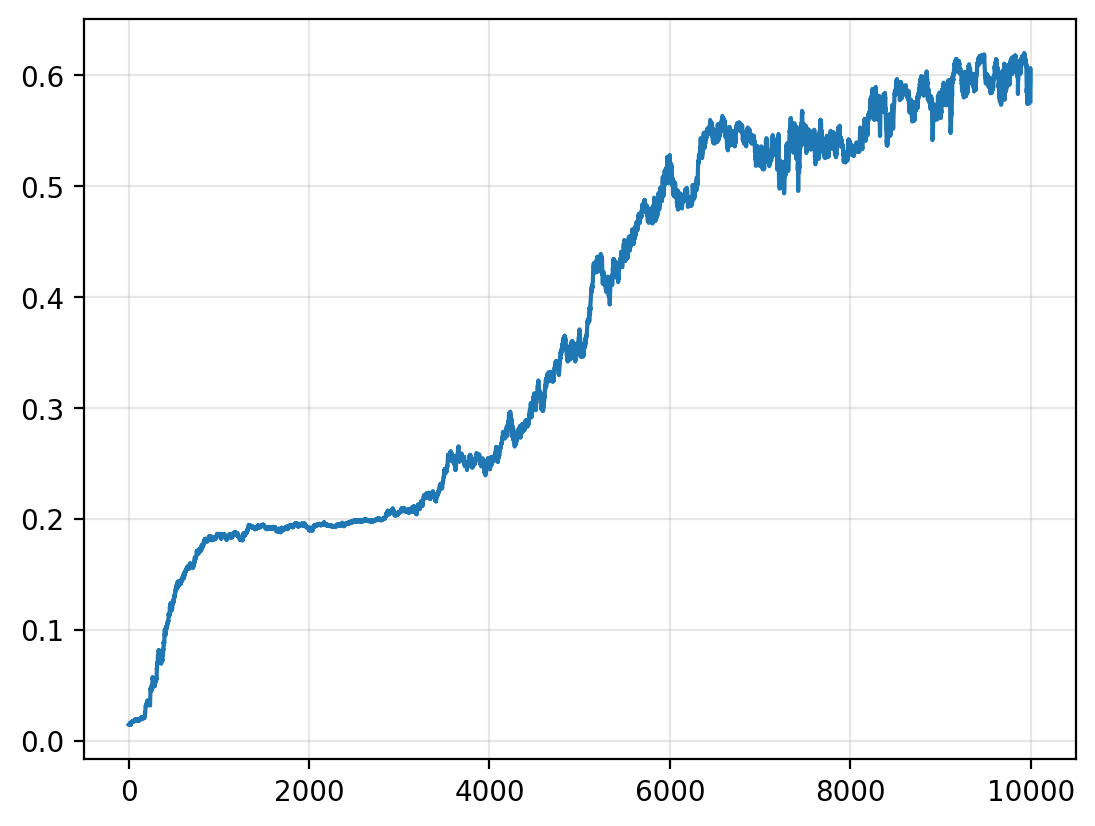

In [146]:
plt.plot(hist_lofi)
plt.grid(alpha=0.3)